#Problème - Session n°2 : une variable cachée

Dans ce problème, on travaille sur un jeu de données comportant 50.000 entrées $x_i$ et des cibles $y_i$. Les entrées sont des vecteurs de taille 10 (au format torch), les cibles sont des scalaires construits à partir de cinq fonctions différentes ($f_0$, ..., $f_4$) : \

$$ \forall i, \exists k\in [\![0 \;;4]\!]  \:\: \text{tel que} \: f_k(x_i) = y_i $$

Ces fonctions sont inconnues, ainsi que l'indice $k$. Par contre, on sait que le groupe des 1000 premières cibles ont été construites à partir du même indice  $k$, de même pour les mille  suivantes, et ainsi de suite.

Le but est de parvenir à rassembler les groupes de cibles qui ont été générées avec le même indice $k$ (avec la même fonction).

In [1]:
# Example d'échantillonnage du dataset
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim

! git clone https://github.com/zakariaabou/exam_2025_session2.git
! cp exam_2025_session2/utils/utils.py .
from utils import Problem1Dataset

dataset = Problem1Dataset()
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

for batch in dataloader:
    x_batch, y_batch, k_batch, idx_batch = batch
    print("Batch input shape:", x_batch.shape)
    print("Batch target shape:", y_batch.shape)
    print("Batch k shape:", k_batch.shape) # indice k (pas utilisable à l'entraînement)
    print("Batch indices shape:", idx_batch.shape)
    break

Cloning into 'exam_2025_session2'...
remote: Enumerating objects: 101, done.
remote: Counting objects: 100% (101/101), done.
remote: Compressing objects: 100% (97/97), done.
remote: Total 101 (delta 31), reused 8 (delta 1), pack-reused 0 (from 0)
Receiving objects: 100% (101/101), 1.40 MiB | 3.59 MiB/s, done.
Resolving deltas: 100% (31/31), done.
Batch input shape: torch.Size([32, 10])
Batch target shape: torch.Size([32, 1])
Batch k shape: torch.Size([32])
Batch indices shape: torch.Size([32])


**Consignes :**
- Entraîner l'architecture proposée dans la cellule suivante.
- Montrer que les vecteurs 2D de self.theta permettent de répondre
  au problème posé.
- Décrire le rôle de self.theta, du vector noise \
 et ainsi que la raison de la division par 1000 (**indices // 1000** dans le code).

In [2]:
class DeepMLP(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim=256):
        super(DeepMLP, self).__init__()
        self.theta = nn.Parameter(torch.randn(50, 2))
        self.fc1 = nn.Linear(input_dim + 2, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x, indices):
        theta_batch = self.theta[indices // 1000, :]
        noise = torch.normal(mean=torch.zeros_like(theta_batch),
                             std=torch.ones_like(theta_batch))
        x = torch.cat([x, theta_batch + noise], dim=1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x, theta_batch

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

# Vérifier si un GPU est disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Définir le modèle et les paramètres
# J'ai utilisé 500 au lieu de 2000 car cela prend beaucoup de temps
num_epochs = 500
batch_size = 32  # A régler
loss_fn = nn.MSELoss()  # Mean Squared Error pour la régression

# Chargement des données
dataset = Problem1Dataset()
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Initialisation du modèle
input_dim = 10  # Les entrées sont des vecteurs de taille 10
output_dim = 1   # Les cibles sont des scalaires
model = DeepMLP(input_dim, output_dim).to(device)  # Déplacer le modèle vers le GPU
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Entraînement du modèle
for epoch in range(num_epochs):
    for x_batch, y_batch, _, idx_batch in dataloader:
        # Déplacer les données vers le périphérique (GPU ou CPU)
        x_batch, y_batch, idx_batch = x_batch.to(device), y_batch.to(device), idx_batch.to(device)

        optimizer.zero_grad()
        predictions, _ = model(x_batch, idx_batch)
        loss = loss_fn(predictions, y_batch)
        loss.backward()
        optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}")

Epoch 10/500, Loss: 19.767757415771484
Epoch 20/500, Loss: 3.383371114730835
Epoch 30/500, Loss: 2.226985454559326
Epoch 40/500, Loss: 1.465162754058838
Epoch 50/500, Loss: 1.3934561014175415
Epoch 60/500, Loss: 0.8058392405509949
Epoch 70/500, Loss: 0.4197617173194885
Epoch 80/500, Loss: 0.5341144800186157
Epoch 90/500, Loss: 0.6725149154663086
Epoch 100/500, Loss: 0.47523653507232666
Epoch 110/500, Loss: 0.7002615332603455
Epoch 120/500, Loss: 0.5910447835922241
Epoch 130/500, Loss: 0.7235008478164673
Epoch 140/500, Loss: 0.6092350482940674
Epoch 150/500, Loss: 0.4122421145439148
Epoch 160/500, Loss: 0.7145518660545349
Epoch 170/500, Loss: 0.692379355430603
Epoch 180/500, Loss: 0.5032064914703369
Epoch 190/500, Loss: 0.8663976192474365
Epoch 200/500, Loss: 0.590544581413269
Epoch 210/500, Loss: 0.5597082376480103
Epoch 220/500, Loss: 0.5058039426803589
Epoch 230/500, Loss: 0.2400279939174652
Epoch 240/500, Loss: 0.35724735260009766
Epoch 250/500, Loss: 0.6173841953277588
Epoch 260/50

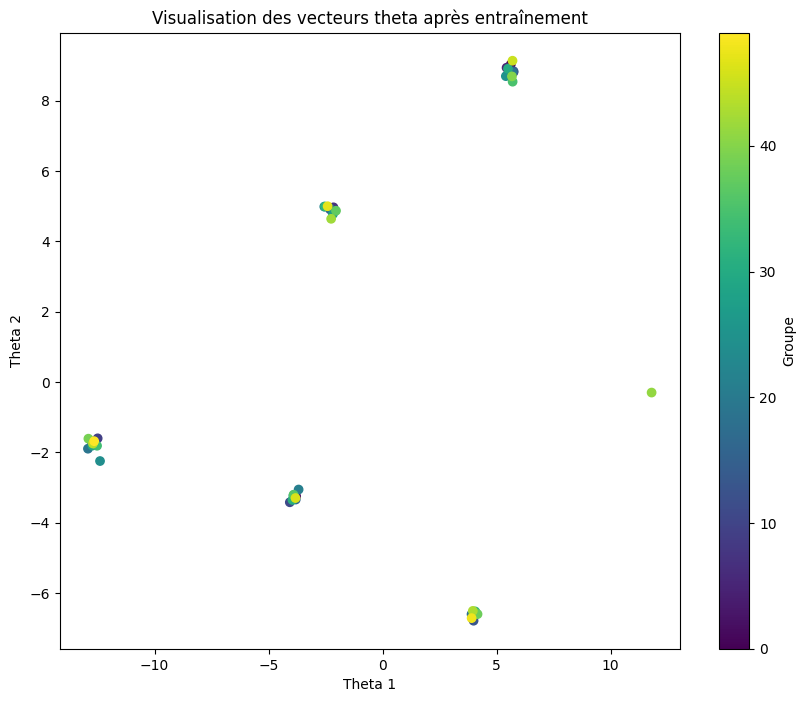

In [5]:
import matplotlib.pyplot as plt

# Récupération des vecteurs theta après entraînement
theta = model.theta.detach().cpu().numpy()

# Visualisation des vecteurs theta
plt.figure(figsize=(10, 8))
plt.scatter(theta[:, 0], theta[:, 1], c=range(50), cmap='viridis')
plt.colorbar(label='Groupe')
plt.title("Visualisation des vecteurs theta après entraînement")
plt.xlabel("Theta 1")
plt.ylabel("Theta 2")
plt.show()